In [1]:
import numpy as np
import json
import scipy.sparse as sparse
import matplotlib.pylab as plt

In [2]:
# Read DOF Map
def getDOFMap(fname):
    with open(fname, 'r') as dof_file:
      dof_data = json.load(dof_file)

#     print(json.dumps(dof_data, indent = 4))
#     print(json.dumps(dof_data["vars"][0], indent = 4))

    var_num = len(dof_data["vars"])
    dof_num = dof_data["ndof"]

    # Save dofs in DOFs: var_num * dof_per_var
    DOFs = []
    for var in dof_data["vars"]:
        DOF_list = []
        for dm in var["subdomains"]:
            id = dm["id"]
            dofs = dm["dofs"]
            DOF_list += dofs
        DOFs.append(DOF_list)
    return DOFs, dof_num

In [3]:
# Get DOF list for variable name "Var" and subdomain "ID"
def getDOFMapVarID(fname, Var, ID):
    with open(fname, 'r') as dof_file:
      dof_data = json.load(dof_file)
    for var in dof_data["vars"]:
        if Var == var["name"]:
            for dm in var["subdomains"]:
                if ID == dm["id"]:
                    return dm["dofs"]

In [4]:
# Read Matrix 
def getJacobianMatrix(fname, tol):
    data = open(fname, 'r')
    if data.mode == 'r':
        lines = data.readlines()
        lin_num = 0
        # Matrix size
        row_num = 0
        col_num = 0
        # Total nonzeros
        nonzero_num = 0
        # Row and Col indices
        row_ind = []
        col_ind = []
        vals = []
        for line in lines:
            lin_num = lin_num +1
            if lin_num == 3: # get matrix size
                tmp = [int(i) for i in line.split() if i.isdigit()] 
                row_num = tmp[0]
                col_num = tmp[1]
            if lin_num == 4: # get number of nonzeros
                tmp = [int(i) for i in line.split() if i.isdigit()]
                nonzero_num = tmp[0]
            if lin_num > 6 and lin_num - nonzero_num< 7: # get each nonzero entry
                tmp = list( map( float,  filter( None  , [ x for x in line.strip().split(' ') ] )) )
                if abs(tmp[2])> tol:
                    row_ind.append(int(tmp[0]))
                    col_ind.append(int(tmp[1]))
                    vals.append(tmp[2])
                    #print([idx, idy, val])
#     print(len(vals))            
    MAT = sparse.coo_matrix((vals, (row_ind, col_ind)))
    return MAT, len(vals)

# print(MAT.tocsc())
# visualize the sparse matrix with Spy
# plt.spy(MAT, markersize=1)

In [5]:
def coo_submatrix_pull(matr, rows, cols):
    """
    Pulls out an arbitrary i.e. non-contiguous submatrix out of
    a sparse.coo_matrix. 
    """
    if type(matr) != sparse.coo_matrix:
        raise TypeError('Matrix must be sparse COOrdinate format')
    
    gr = -1 * np.ones(matr.shape[0])
    gc = -1 * np.ones(matr.shape[1])
    
    lr = len(rows)
    lc = len(cols)
    
    ar = np.arange(0, lr)
    ac = np.arange(0, lc)
    gr[rows[ar]] = ar
    gc[cols[ac]] = ac
    mrow = matr.row
    mcol = matr.col
    newelem = (gr[mrow] > -1) & (gc[mcol] > -1)
    newrows = mrow[newelem]
    newcols = mcol[newelem]
    return sparse.coo_matrix((matr.data[newelem], np.array([gr[newrows], gc[newcols]])),(lr, lc))

In [6]:
refine = 2;
dof_map, dof_num = getDOFMap('contact_sliding_LU_refine_'+str(refine)+'_out.json')
dual_mat, dual_nonzeros = getJacobianMatrix('./dual_matrix_ref'+str(refine)+'.m', 1e-8)
mat, nonzeros = getJacobianMatrix('./matrix_ref'+str(refine)+'.m', 1e-8)

ux1_dofs = getDOFMapVarID('contact_sliding_LU_refine_'+str(refine)+'_out.json', 'disp_x', 1)
ux2_dofs = getDOFMapVarID('contact_sliding_LU_refine_'+str(refine)+'_out.json', 'disp_x', 2)

uy1_dofs = getDOFMapVarID('contact_sliding_LU_refine_'+str(refine)+'_out.json', 'disp_y', 1)
uy2_dofs = getDOFMapVarID('contact_sliding_LU_refine_'+str(refine)+'_out.json', 'disp_y', 2)

lm_dofs = getDOFMapVarID('contact_sliding_LU_refine_'+str(refine)+'_out.json', 'leftright_normal_lm', 4)

# print(dof_map)

# print(ux1_dofs)
# print(ux2_dofs)
# print(uy1_dofs)
# print(uy2_dofs)

disp_1_dofs=ux1_dofs+uy1_dofs
disp_2_dofs=ux2_dofs+uy2_dofs

disp_1_dofs.sort()
disp_2_dofs.sort()

# print(disp_1_dofs)

# print(disp_2_dofs)


print("dual nonzeros: " + str(dual_nonzeros) + "; nonzeros: " +str(nonzeros)+ "; Difference: "+ str(nonzeros-dual_nonzeros))

dual nonzeros: 8708; nonzeros: 8732; Difference: 24


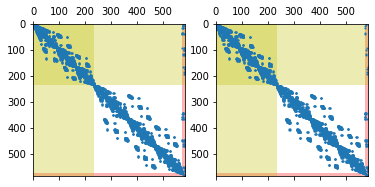

In [7]:
fig = plt.figure()

# submat = coo_submatrix_pull(mat, np.array(dof_map[1])+1, np.array(u1_dofs)+1)
# submat_ur = coo_submatrix_pull(mat, np.array(u1_dofs)+1, np.array(dof_map[1])+1)
plt.subplot(1, 2, 1)
plt.axhspan(np.array(lm_dofs)[0]+1, np.array(lm_dofs)[-1]+1, facecolor='r', alpha=0.3,zorder=-100)
plt.axvspan(np.array(lm_dofs)[0]+1, np.array(lm_dofs)[-1]+1, facecolor='r', alpha=0.3,zorder=-100)
plt.axhspan(np.array(disp_1_dofs)[0]+1, np.array(disp_1_dofs)[-1]+1, facecolor='y', alpha=0.3,zorder=-100)
plt.axvspan(np.array(disp_1_dofs)[0]+1, np.array(disp_1_dofs)[-1]+1, facecolor='y', alpha=0.3,zorder=-100)
plt.spy(mat, markersize=1)
# nonzeros = np.count_nonzero(submat.toarray())
# nonzeros_ur = np.count_nonzero(submat_ur.toarray())

# dual_submat = coo_submatrix_pull(dual_mat, np.array(dof_map[1])+1, np.array(u1_dofs)+1)
# dual_submat_ur = coo_submatrix_pull(dual_mat, np.array(u1_dofs)+1, np.array(dof_map[1])+1)
plt.subplot(1, 2, 2)
plt.axhspan(np.array(lm_dofs)[0]+1, np.array(lm_dofs)[-1]+1, facecolor='r', alpha=0.3,zorder=-100)
plt.axvspan(np.array(lm_dofs)[0]+1, np.array(lm_dofs)[-1]+1, facecolor='r', alpha=0.3,zorder=-100)
plt.axhspan(np.array(disp_1_dofs)[0]+1, np.array(disp_1_dofs)[-1]+1, facecolor='y', alpha=0.3,zorder=-100)
plt.axvspan(np.array(disp_1_dofs)[0]+1, np.array(disp_1_dofs)[-1]+1, facecolor='y', alpha=0.3,zorder=-100)
plt.spy(dual_mat, markersize=1)

# dual_nonzeros = np.count_nonzero(dual_submat.toarray())
# dual_nonzeros_ur = np.count_nonzero(dual_submat_ur.toarray())

# fname = '/Users/yushd/Desktop/Jacobian_nonconform_refine'+str(refine)+'.pdf'
# plt.savefig(fname)

# print("LM dofs: "+str(len(dof_map[-1])))
# print("lower-left dual nonzeros: " + str(dual_nonzeros) + "; lower-left nonzeros: " +str(nonzeros)+ "; Difference: "+ str(nonzeros-dual_nonzeros))
# print("upper-right dual nonzeros: " + str(dual_nonzeros_ur) + "; upper-right nonzeros: " +str(nonzeros_ur)+ "; Difference: "+ str(nonzeros_ur-dual_nonzeros_ur))

In [8]:
# fig.savefig('case2_mortar_contact_Jacobian_compare_ref'+str(refine)+'.pdf', bbox_inches='tight')

In [9]:
print(len(lm_dofs))

13
